In [1]:
import pypesto
import pypesto.petab
import pypesto.optimize as optimize
import pypesto.sample as sample
import pypesto.visualize as visualize
import matplotlib.pyplot as plt
import seaborn as sns

import petab
import numpy as np
from scipy.special import gammaln
from scipy.special import gamma
import pickle
from copy import deepcopy

datatype = "original"

# import to petab
if datatype == "original":
    petab_problem = petab.Problem.from_yaml(
    "corrupted_data/SS_conversion_reaction_original.yaml")
elif datatype == "switch":
    petab_problem = petab.Problem.from_yaml(
    "corrupted_data/SS_conversion_reaction_switch.yaml")
elif datatype == "loss":
    petab_problem = petab.Problem.from_yaml(
    "corrupted_data/SS_conversion_reaction_loss.yaml")

In [2]:
def analytical_b(t, a0, b0, k1, k2):
    return (k2 - k2 * np.exp(-(k2 + k1) * t)) / (k2 + k1)

def simulate_model(x, tvec):
    # assign parameters
    k1, k2, _ = x
    # define initial conditions
    a0 = 1
    b0 = 0
    # simulate model
    simulation = [analytical_b(t, a0, b0, k1, k2)
                   for t in tvec]
    return simulation

After importing the model, we need to define the objective function. This time we will do it via an external function that will be used then by pyPESTO instead of using the built-in ones.

For numerical reasons we will implement the log likelihood and log prior.

\begin{align*}
    p(D|\theta,\sigma) =& \frac{\sigma \lambda}{(2 \sigma)^N} \Biggl( \frac{1}{N -2r - \sigma\lambda} \cdot \Biggl(\exp\biggl( \frac{b_{r + 1}(N - 2r) + l_r}{\sigma} - b_{r + 1}\lambda \biggr) - \exp \biggl( \frac{l_r}{\sigma} \biggr) \Biggr) \\
    &+ \sum_{i = r + 1}^{N-1} \frac{1}{N -2i - \sigma\lambda} \cdot \Biggl(\exp\biggl( \frac{b_{i + 1}(N - 2i) + l_i}{\sigma} - b_{i + 1}\lambda \biggr) - \exp\biggl( \frac{b_{i}(N - 2i) + l_i}{\sigma} - b_{i}\lambda \biggr) \Biggr) \\
    &+ \frac{1}{N + \sigma\lambda} \cdot \exp \biggl(\frac{-b_N N + l_N}{\sigma} - b_N \lambda \biggr) \Biggr)
 \end{align*}

In [3]:
def negative_log_marginalised_likelihood(x):
    scale = x[2]
    
    data = np.asarray(petab_problem.measurement_df.measurement)
    tvec = np.asarray(petab_problem.measurement_df.time)
    N = len(tvec)
    
    # simulate model
    _simulation = simulate_model(np.exp(x), tvec)
    simulation = np.asarray(_simulation)
    
    # evaluate standard log likelihood
    res = data - simulation
    b_vector = np.sort(res)
    
    bounds = np.append(np.append(-np.inf, b_vector), np.inf)
    r = np.argmax(bounds >= 0)-1
    
    marginal_posterior = 0
    for n in range(r, N + 1):
        l_value = np.sum(b_vector[:n]) - np.sum(b_vector[n:])
        tmp = l_value/scale
        if n == r:
            aux1 = 1/(N-2*r-scale*lamda)
            aux2 = (np.exp(tmp+bounds[r+1]*((N-2*r)/scale-lamda))-np.exp(tmp))

        elif n == N:
            aux1 = 1/(N+scale*lamda)
            aux2 = np.exp(tmp+bounds[n]*(-N/scale-lamda))

        else:
            aux = (N-2*n)/scale-lamda
            aux1 = 1/(N-2*n-scale*lamda)
            aux2 = np.exp(tmp+bounds[n+1]*aux)-np.exp(tmp+bounds[n]*aux)
        
        marginal_posterior += aux1*aux2
        
    log_marginal_posterior = np.log(marginal_posterior)
    log_marginal_posterior += -N*(np.log(2) + np.log(scale)) + np.log(lamda) + np.log(scale) 
    
    return -log_marginal_posterior

Now that we have the objective function defined, we need to create a pyPESTO problem.

In [4]:
def marginal_sampling():
    """Creates a pyPESTO problem."""
    objective = pypesto.Objective(fun=negative_log_marginalised_likelihood)
    problem = pypesto.Problem(objective=objective,  # objective function
                              lb=[-5, -5, 0],  # lower bounds
                              ub=[5, 5, np.inf],  # upper bounds
                              x_names=['k1', 'k2', 'scale'],  # parameter names
                              x_scales=['log', 'log', 'lin'])  # parameter scale
    return problem

In [5]:
### Prior dependent paramters
lamda = 0.01

# create the estimation problem
problem = marginal_sampling()

# MCMC chain length
n_samples= 1e5

# call the sampler of choice
sampler = sample.AdaptiveMetropolisSampler()

x0=np.array([-1.2741, -0.6160, 0.3684])

Now we can perform the actual sampling.

In [6]:
# Define number of runs
runs = 1

save_results = False # for testing just set to False

# Loop over n runs
for n in range(runs):
    # set initial random seed
    np.random.seed(n)
    # perform MCMC sampling
    result = sample.sample(problem, n_samples=n_samples, sampler=sampler,
                           x0=x0)
    # calculate effective sample size
    sample.effective_sample_size(result=result)

    # save the results as a pickle object
    if save_results:
        results = [result.sample_result]
        with open('Results/Offset_marginalized/' + str(n) + '.pickle','wb') as result_file:
            pickle.dump(results, result_file, n)

100%|██████████| 1000000/1000000 [15:02<00:00, 1108.53it/s]


There are some built-in visualization functions that one can use.

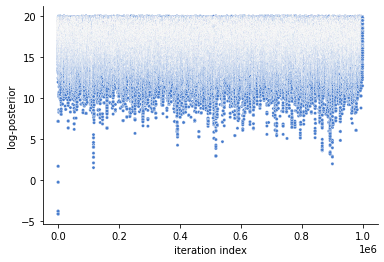

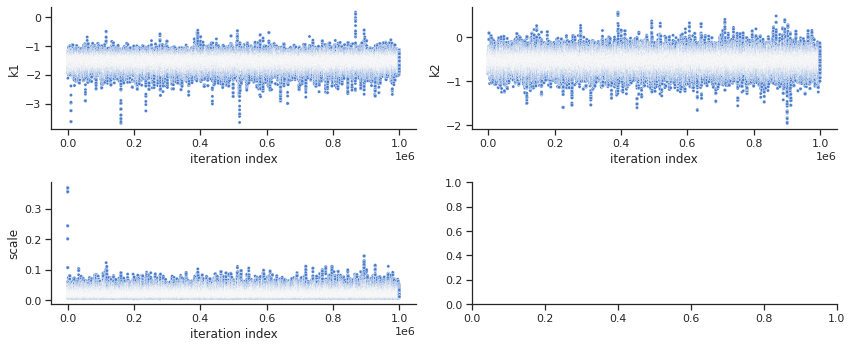

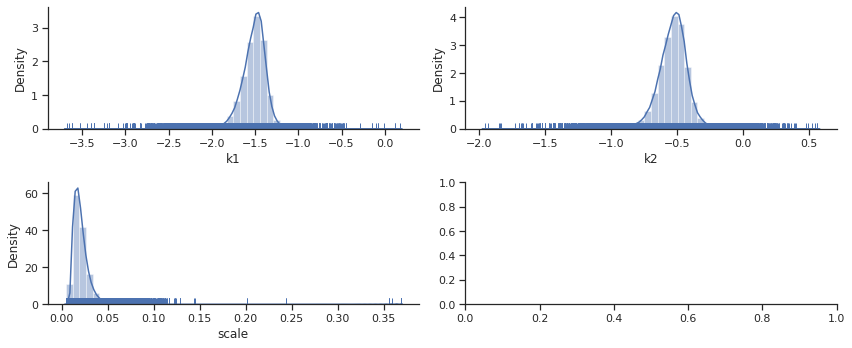

In [7]:
ax = visualize.sampling_fval_traces(result,full_trace=True)
# Visualize the parameter trace
ax = visualize.sampling.sampling_parameter_traces(result, use_problem_bounds=False,
                                                  full_trace=True, size=(12,5))
# Visualize the one-dimensional marginals --> Important!
ax = visualize.sampling_1d_marginals(result, size=(12,5))

Now we want to sample the offset $c$ from our generated data. It is distributed as a piecewise exponential distribution with this density function:

\begin{align*}
    \mathbf{1}_{[0, b_{r + 1})}(c) \exp\biggl( c \cdot \biggl( \frac{N - 2r}{\sigma} - \lambda \biggr) + \frac{l_r}{\sigma} \biggr) + \sum_{i = r + 1}^N \mathbf{1}_{[b_i, b_{i + 1})}(c) \exp \biggl( c \cdot \biggl( \frac{N - 2i}{\sigma} - \lambda \biggr) + \frac{l_i}{\sigma} \biggr)
\end{align*}

To sample this distribution we also need the mass of the corresponding integral over every section:

\begin{align*}
I_r &= \frac{1}{N -2r - \lambda\sigma} \cdot \Biggl(\exp\biggl( \frac{b_{r + 1}(N - 2r) + l_r}{\sigma} - b_{r + 1}\lambda \biggr) - \exp \biggl( \frac{l_r}{\sigma} \biggr) \Biggr)\\
I_{i = r+1, \ldots, N-1} &= \frac{1}{N -2i - \lambda\sigma} \cdot \Biggl(\exp\biggl( \frac{b_{i + 1}(N - 2i) + l_i}{\sigma} - b_{i + 1}\lambda \biggr) - \exp\biggl( \frac{b_{i}(N - 2i) + l_i}{\sigma} - b_{i}\lambda \biggr) \Biggr) \\
I_N &= \frac{1}{N + \lambda\sigma} \cdot \exp \biggl(\frac{-b_N N + l_N}{\sigma} - b_N \lambda \biggr)
\end{align*}

As we have a piecewise defined probability distribution we use the weights of the corresponding integrals to choose with a uniformly distributed random variable $s$ in which part we are sampling. Afterwards we generate an exponentially distributed random variable which has only values in that interval.

1. Sample uniformly distributed $s_1$ and determine smallest $i \in \{r, \ldots, N\}$ such that $s_1 \leq \frac{\sum_{k = r}^i I_k}{\sum_{l = r}^N I_l}$

2. We now want to sample an exponential distributed random variable but only inside of $[b_{i-1}, b_i]$ (with $b_{r-1} \equiv 0$).

3. For this we can use the trasnformation $b_{i - 1} - C_i \log\left(E_i + (1-E_I) s_2 \right)$ Hereby is $s_2$ a different uniformly distributed random variable. $C_i$ is the shape parameter of the corresponding exponential distribution. $b_{i - 1}$ is in the code noted as staring value.

4. $E_i$ is later noted as the edge value and is necessary to assure that we only sample the exponential distribution inside the borders. It is defined as $E_i \equiv \exp\left( - C_i \left( b_i - b_{i - 1} \right) \right)$

I oriented on the following response https://math.stackexchange.com/questions/3512581/generating-samples-from-a-piecewise-probability-density-function


In [8]:
def get_offset(data, simulation, scale, lamda):
    res = data - simulation
    b_vector = np.sort(res)
    
    N = len(data)
    
    bounds = np.append(np.append(-np.inf, b_vector), np.inf)
    r = np.argmax(bounds >= 0)-1
    
    probability_mass = np.zeros(N-r+1)
    normalisation_constant = 0

    
    for n in range(r, N + 1):
        l_value = np.sum(b_vector[:n]) - np.sum(b_vector[n:])
        tmp = l_value/scale
        if n == r:
            aux1 = 1/(N-2*r-scale*lamda)
            aux2 = (np.exp(tmp+bounds[r+1]*((N-2*r)/scale-lamda))-np.exp(tmp))
            probability_mass[0] = aux1 * aux2

        elif n == N:
            aux1 = 1/(N+scale*lamda)
            aux2 = np.exp(tmp+bounds[n]*(-N/scale-lamda))
            normalisation_constant = probability_mass[n-r-1] + aux1 * aux2

        else:
            aux = (N-2*n)/scale-lamda
            aux1 = 1/(N-2*n-scale*lamda)
            aux2 = np.exp(tmp+bounds[n+1]*aux)-np.exp(tmp+bounds[n]*aux)
            probability_mass[n - r] = probability_mass[n-r-1] + aux1 * aux2
            
    
    probability_mass = probability_mass / normalisation_constant
    probability_mass[N-r] = 1
    
    s = Generator.uniform(size = 2)
    i = np.argmax(probability_mass > s[0])
    distr_val = (N - 2*i)/scale - lamda
    
    if i == 0:
        edge_value = np.exp(-distr_val * bounds[r + 1])
        start_value = bounds[r + 1]
        
    elif i == N-r:
        edge_value = 0
        start_value = bounds[N]
        
    elif distr_val > 0:
        edge_value = np.exp(-distr_val * (bounds[i + 1] - bounds[i]))
        start_value = bounds[i + r + 1]
            
    else:
        edge_value = np.exp(-distr_val * (bounds[i + 1] - bounds[i]))
        start_value = bounds[i + r]
        
    if distr_val > 0:
        offset = start_value + np.log(edge_value + (1 - edge_value) * s[1])/distr_val
        
    else:
        offset = start_value - np.log(edge_value + (1 - edge_value) * s[1])/distr_val
    
    return offset

In [9]:
tvec = np.asarray(petab_problem.measurement_df.time)
data = np.asarray(petab_problem.measurement_df.measurement)

Generator = np.random.default_rng()

offset_samples = np.zeros([np.shape(
    result.sample_result.trace_x[0, result.sample_result.burn_in:, 0])[0], 1])

for index, parameter_sample in enumerate(result.sample_result.trace_x[0, result.sample_result.burn_in:, :]):
    scale = parameter_sample[-1]
    _simulation = simulate_model(np.exp(parameter_sample), tvec)
    simulation = np.asarray(_simulation)
    
    offset_samples[index, :] = get_offset(data, simulation, scale, lamda)
    
if save_results:
    results = [result.sample_result, offset_samples]
    with open('Results/Offset_marginalized/' + str(n) + '.pickle','wb') as result_file:
        pickle.dump(results, result_file, n)

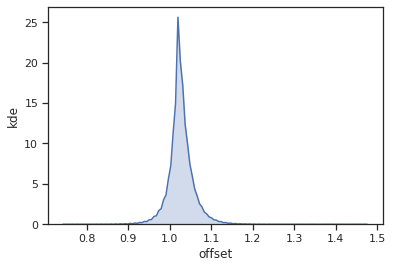

In [10]:
plt.figure()
ax = sns.kdeplot(offset_samples[:,0], shade=True, color='C0')
plt.xlabel('offset')
plt.ylabel('kde')
plt.show()

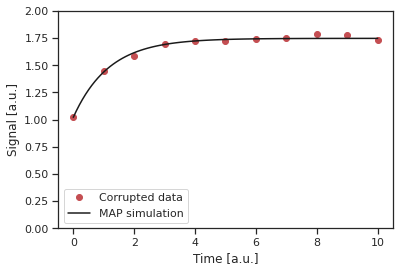

In [11]:
plot_MAP = True

if plot_MAP:
    MAP_index=np.argmax(-result.sample_result.trace_neglogpost[0,result.sample_result.burn_in:])
    MAP = result.sample_result.trace_x[0,result.sample_result.burn_in+MAP_index,:]
    
    # experimental data
    data = np.asarray(petab_problem.measurement_df.measurement)
    # time vector
    tvec = np.asarray(petab_problem.measurement_df.time)

    tvec_for_plotting = np.linspace(tvec[0],tvec[-1],100)
    
    scale_MAP = MAP[-1]

    # simulate model
    _simulation = simulate_model(np.exp(MAP), tvec)
    simulation = np.asarray(_simulation)
    
    offset_MAP = get_offset(data, simulation, scale_MAP, lamda)
    
    _simulation = simulate_model(np.exp(MAP), tvec_for_plotting)
    simulation_for_plotting = np.asarray(offset_MAP + _simulation)
    
    import matplotlib.pyplot as plt

    plt.figure()
    plt.plot(tvec,data,'or',label='Corrupted data')
    plt.plot(tvec_for_plotting,simulation_for_plotting,'k',label='MAP simulation')
    plt.xlabel('Time [a.u.]')
    plt.ylabel('Signal [a.u.]')
    plt.ylim([0,2])
    plt.legend()
    plt.show()